In [14]:
import json
import string
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import cuda

from sklearn.preprocessing import LabelEncoder

from config import Config
from dataset import Dataset
from model import Model


df = pd.read_csv('data\dataset.csv')


le = LabelEncoder().fit(df['labels'])
df['labels'] = le.transform(df['labels'])

device = 'cuda' if cuda.is_available() else 'cpu'

state_dict = torch.load('model.pt', map_location=torch.device(device))

num_tag = len(df.labels.value_counts())

model = Model(num_tag=num_tag)

# Load the state dictionary into model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [16]:
# Open the JSON file for reading
with open('demo.json', 'r') as json_file:
    # Load the JSON data
    data = json.load(json_file)

# Now 'data' contains the content of the JSON file as a Python object (e.g., dict, list, etc.)
train_losses = data["train_losses"]
val_losses = data["val_losses"]
best_loss = data["best_loss"]
best_epoch = data["best_epoch"]

In [21]:
print(len(train_losses))

10


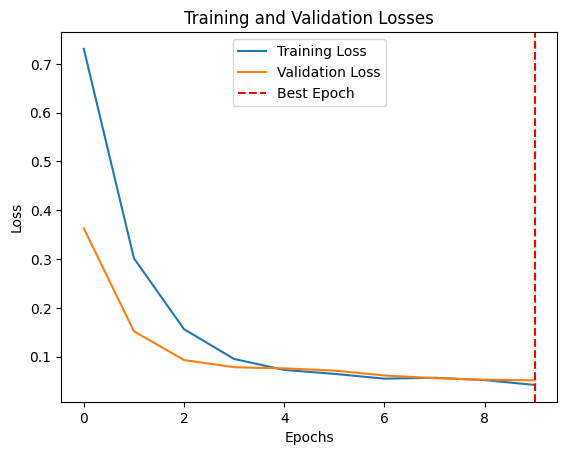

In [22]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Mark the epoch with the lowest validation loss with a vertical line
plt.axvline(x=best_epoch-1, color='r', linestyle='--', label='Best Epoch')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Show the plot
plt.show()

In [19]:
def prediction(test_sentence, model, le):
    for i in list(string.punctuation):
        test_sentence = test_sentence.replace(i, ' ' + i)
    test_sentence = test_sentence.split()
    print(test_sentence)
    Token_inputs = Config.TOKENIZER.encode(test_sentence, add_special_tokens=False)
    print(Token_inputs)
    test_dataset =  Dataset(test_sentence, tags= [[1] * len(test_sentence)], tokenizer=Config.TOKENIZER)
    num_tag = len(le.classes_)
   
    with torch.no_grad():
        data = test_dataset[0]
        for i, j in data.items():
            data[i] = j.to(device).unsqueeze(0)
        tag, _ = model(**data)

        print(le.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))[1:len(Token_inputs)+1])
        


In [20]:
test_sentences = [
    "Makovytsia, with its accessible trails, is suitable for hikers of all skill levels.",
    "Petros' summit, kissed by the first light of dawn, is a magical moment for early risers.",
    "Shpici, hidden away from the tourist crowds, provides a tranquil escape for those seeking solitude.",
    "The valleys surrounding Hoverla are home to unique plant species adapted to the mountainous climate.",
    "Sinyak's craggy peaks are silhouetted against the evening sky, creating a dramatic scene.",
    "Makovytsia's diverse ecosystem supports a variety of wildlife, from butterflies to elusive mammals.",
    "Petros, with its challenging ascent, attracts climbers from around the world.",
    "Shpici's remote location allows for stargazing, offering a clear view of the night sky."
    ]

for test_sentence in test_sentences:
    prediction(test_sentence, model, le)

['Makovytsia', ',', 'with', 'its', 'accessible', 'trails', ',', 'is', 'suitable', 'for', 'hikers', 'of', 'all', 'skill', 'levels', '.']
[100, 1010, 2007, 2049, 7801, 9612, 1010, 2003, 7218, 2005, 100, 1997, 2035, 8066, 3798, 1012]
['B-MOUNTAIN' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-MOUNTAIN' 'O'
 'B-MOUNTAIN' 'O' 'B-MOUNTAIN' 'O']
['Petros', "'", 'summit', ',', 'kissed', 'by', 'the', 'first', 'light', 'of', 'dawn', ',', 'is', 'a', 'magical', 'moment', 'for', 'early', 'risers', '.']
[100, 1005, 6465, 1010, 4782, 2011, 1996, 2034, 2422, 1997, 6440, 1010, 2003, 1037, 8687, 2617, 2005, 2220, 100, 1012]
['B-MOUNTAIN' 'O' 'O' 'O' 'O' 'O' 'B-MOUNTAIN' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O']
['Shpici', ',', 'hidden', 'away', 'from', 'the', 'tourist', 'crowds', ',', 'provides', 'a', 'tranquil', 'escape', 'for', 'those', 'seeking', 'solitude', '.']
[100, 1010, 5023, 2185, 2013, 1996, 7538, 12783, 1010, 3640, 1037, 100, 4019, 2005, 2216, 6224, 22560, 1012]
['B-MOUNTAIN' 'O' 'O' 'O'